# Natural Language Processing with Disaster Tweets

This notebook is based on the [Fast.AI lesson 4](https://forums.fast.ai/t/lesson-4-official-topic/96441): I am transferring the approach from Jeremy's notebook "[Getting started with NLP for absolute beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)" to the Kaggle competition "[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)".

The approach is the following: Classifying patent phrases or tweets is essentially "the same" task. Like in [my baseline notebook](https://www.kaggle.com/code/christianwittmann/nlp-with-disaster-tweets-baseline) I am training a Hugging Face transformers model to classify the tweets as disasters or not.

In this notebook, I have implemented quite a few improvements, some inspired by the notebook "[Iterate like a grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster)", some by other sources, own research and a lot of trial and error. I probably trained 250+ model and made 70+ submissions, trying to build up intuition on what works and what not. Therefore, please treat this as an empirical report, not as a scientific paper. My best submission scored 0.84676:

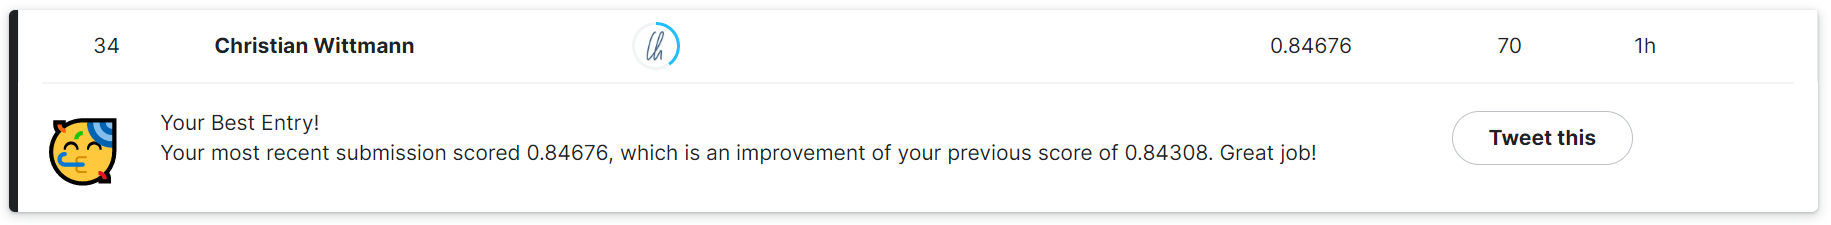

# Summary of Learnings / Improvements

Here are my key learnings, and this notebook takes your through the implementation. For further thoughts on the process, please also [check out my blog post](https://chrwittm.github.io/posts/2023-01-17-nlp-with-disaster-tweets/):

* **Cleaning the data helps, both syntactically and semantically**: Not only did I clean up special (rubbish) character, but also re-classified some tweets, mainly automatically.
* Upon cleaning the data, **keep a close eye on what is noise and what is signal**, for example, converting everything to lower case did not help, because I believe that it removed signal.
* Helping the model understand the data helps by **using special tokens**, for example by replacing URLs with a special token.
* **Using bigger models helps**, on average moving from the small to the base to the large versions of the deberta models increased the score by a few tenth. However, for training large models on Kaggle, you need to apply some tricks not to run out of memory. Additionally, training bigger models is comparable time-consuming.
* **Small batch sizes help** to train models more quickly.
* **Showing the model more data** then just the initial training set helps.

On a side note: I wonder how I would score by hand-labeling all tweets in the test set. **Would I beat the AI or would AI beat me?** Find out in my blog post "[Natural Language Processing with Disaster Tweets](https://chrwittm.github.io/posts/2023-01-17-nlp-with-disaster-tweets/)".


# Preparing the notebook

For the real action in NLP, simply skip over this section. ;)

## Activating the GPU

I mention it, not to forget, and because this is the first time I am writing a complete notebook on Kaggle: Do not forget to activate the GPU:

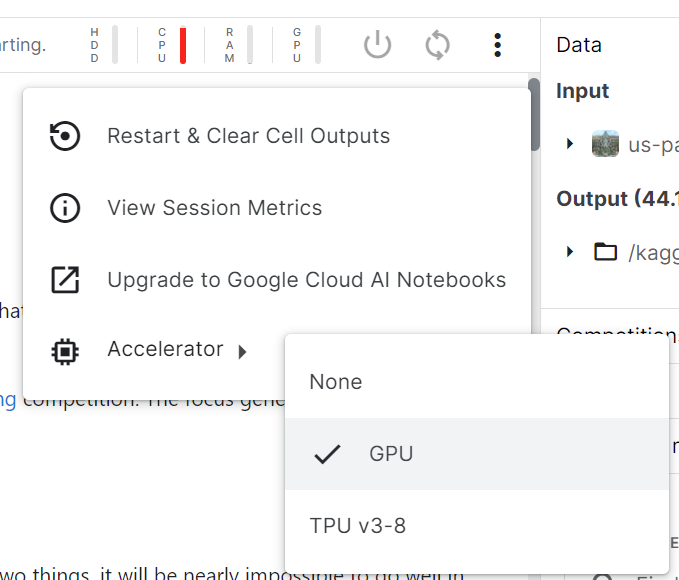

# Downloading the Competition Data

Maybe this is too obvious, but it took me a while to figure out: When you are in Kaggle, you do not download the data via the API in the notebook, but you can simply click on the "Add Data"-button on the top-right... (or is there a more elegant way to do this in the notebook without copy&pasting your credentials into the notebook?)

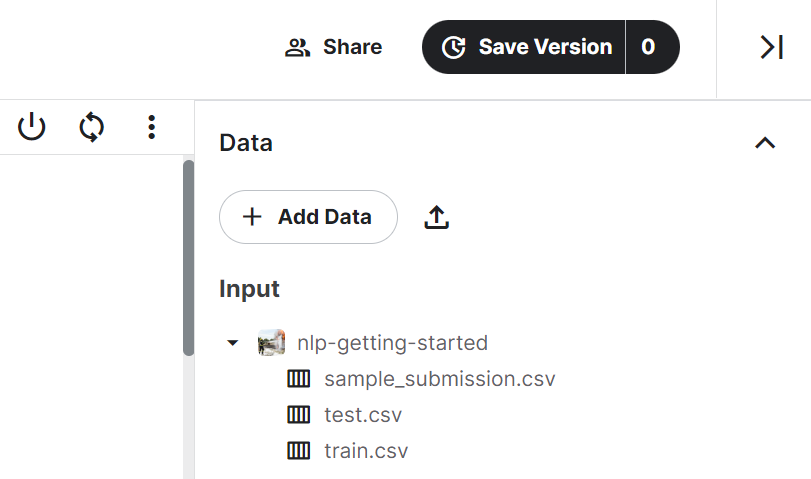

In [1]:
import os

# Get the value of PYTORCH_MPS_HIGH_WATERMARK_RATIO
high_watermark_ratio = os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO')

# Check if the variable is set and print its value
if high_watermark_ratio is not None:
    print(f"PYTORCH_MPS_HIGH_WATERMARK_RATIO is set to: {high_watermark_ratio}")
else:
    print("PYTORCH_MPS_HIGH_WATERMARK_RATIO is not set (using default behavior).")


PYTORCH_MPS_HIGH_WATERMARK_RATIO is not set (using default behavior).


In [2]:
import os

# Set the environment variable
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'  # Adjust the value as needed


In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
iskaggle

''

After having downloaded the data into the Kaggle space, you can access it by adding `../input/` in front of the path/competition name, in our case, the competition name is `nlp-getting-started`, therefore the path is `../input/nlp-getting-started`:

In [4]:
from pathlib import Path

if iskaggle:
    path = Path('../input/nlp-getting-started')
    ! pip install -q datasets
else:
    path = Path('.')

In [5]:
path

PosixPath('.')

In [6]:
!ls {path}

lesson04.md
nlp-getting-started.zip
nlp-with-disaster-tweets-baseline.ipynb
nlp-with-disaster-tweets-january-2023-Apple-Silicon.ipynb
nlp-with-disaster-tweets-january-2023-v2.ipynb
nlp-with-disaster-tweets-january-2023.ipynb
outputs
sample_submission.csv
test.csv
test_manually.xlsx
train.csv
unpublished


## Installing packages in Kaggle

In [7]:
if iskaggle:
    ! pip install -q datasets #from Huggingface
    ! pip install -q evaluate #from Huggingface

## Reducing the Verbosity

In [8]:
import warnings, logging

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

# Preparing the Tokenization

Moving this piece up in the notebook (compared to the baseline) so that we can use special tokens.

I did most of my work with the [`microsoft/deberta-v3-small`](https://huggingface.co/microsoft/deberta-v3-small) model, simply because training was quite fast. To improve the score, I also upgraded to bigger models. You can simply set the parameter here:

In [9]:
#model_nm = 'microsoft/deberta-v3-small'
#model_nm = 'microsoft/deberta-v3-base' # size does seem to matter
model_nm = 'microsoft/deberta-v3-large' # size does seem to matter

Let's do the tokenization:

In [10]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

The following special tokens are already defined:

In [11]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

Chatting with ChatGTP, I learned about the usage of the predefined special tokens: (I hope the following is accurate)

* The "`[CLS]`"-special token ("classification token") is used to represent the entire input sequence in tasks such as text classification, sentiment analysis and named entity recognition etc. The token is added to the beginning of the input sequence and is then passed through the model along with the rest of the input. In the context of disaster tweets, if a tweet was "There is a fire", after adding the token, the tweet looked like this: "[CLS] There is a fire". In the final version of the notebook I did add the [CLS]-token to all the tweets, but I did not notice any improvement in model performance.
* The "`[SEP]`"-special token ("separation token") is used to separate multiple sentences or segments within a single input sequence. The token is added at the end of each sentence or segment, and is used to indicate the end of one segment and the beginning of another. I did not add any [SEP]-tokens to the tweets because a tweet is a unit of its own. Interestingly, the tokens for `.` and `[SEP]` are not the same, which makes sense, because not any `.`-character is automatically a separator.  
* The "`[UNK]`"-special token is used to represent unknown or out-of-vocabulary words that the model has not seen during training. During the preprocessing step, any word that is not in the vocabulary is replaced with the "[UNK]" token. Somehow I would have expected the tokenizer to replace unknown words with [UNK], but that did not happen whatever I tried.
* The "`[PAD]`"-special token is used to pad the input sequences to a fixed length. A BERT (and deberta) model is a transformer-based model which requires that all input sequences have the same length before they can be passed through the model. I did not use this token, but I trust the inner mechanics of the model to take care of this.
* The "`[MASK]`"-special token is used in the pre-training process called Masked Language Model (MLM). In this task, a proportion of tokens in the input sequence is replaced with the "[MASK]" token, and the model is trained to predict the original token that was replaced by the "[MASK]" token. This pre-training process allows the model to learn the context of the words in the sentence and understand the relationship between words in the sentence. Since this is a token used in training, I did not use it in my notebooks.

In [12]:
#Notice: the tokens for `.` and `[SEP]` are not the same
tokz.vocab['[SEP]'], tokz.vocab['.'] 

(2, 260)

In [13]:
new_token_list = [
    "[MB]", #mention beginning
    "[ME]", #mention end
    "[U]",  #URL
    "[HB]", #hashtag beginning
    "[HE]"  #hashtag end
]

tokz.add_special_tokens({'additional_special_tokens': new_token_list})

5

In [14]:
tokz.all_special_tokens

['[CLS]',
 '[SEP]',
 '[UNK]',
 '[PAD]',
 '[MASK]',
 '[MB]',
 '[ME]',
 '[U]',
 '[HB]',
 '[HE]']

## Unicode Experiments

One of the source of special / rubbish characters in the tweets seem to be erroneous conversions from unicode: In the following I try to derive a mapping from special character to real character - not all of it successful. Some of the results, for example, `Ûª` which should be `'` is used later in the code for replacement.

In [15]:
ord("😉")

128521

In [16]:
string = "😉"

# Encode from Unicode to bytes
string.encode("utf-8")

b'\xf0\x9f\x98\x89'

In [17]:
b'\xf0\x9f\x98\x89'.decode("utf-8")

'😉'

In [18]:
hex(ord("Û")), hex(ord("")), hex(ord("ª"))

('0xdb', '0x89', '0xaa')

In [19]:
(bytes([ord("Û")]) + bytes([ord("ª")])).decode("utf-8")

'۪'

In [20]:
b'\xdb\xaa'.decode("utf-8")

'۪'

In [21]:
string = "Ûª"
#string = "åÊ" #'-'?
#string = "ÛÓ"
#string = "Û_"
#string = "ÛÏ"
#string = "Û"
converted_string = bytes()
for letter in string:
    converted_string += bytes([ord(letter)])
    
converted_string.decode("utf-8")

'۪'

# Inspecting/Cleaning the Data

In [22]:
import pandas as pd

pd.options.display.max_colwidth = 200

train = pd.read_csv(path/"train.csv")
train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


Upon first inspection of the head of the training data it becomes apparent that it is not quite obvious what is a disaster and what not. A "Forest fire near La Ronge Sask" may be an obvious desaster, but "What a goooooooaaaaaal!!!!!!" would only be a disaster for the fans of one team. 😜

More on the classification of the tweets later, let's focus on the formatting of the tweets first. There are quite a few problems to fix. Here are some examples of problematic tweets:

In [23]:
def display_problematic_lines1():

    return train.loc[(train['id'] == 6) |
                     (train['id'] == 54) |
                    # (train['id'] == 1771) |
                     (train['id'] == 5937) |
                     (train['id'] == 5876) |
                     (train['id'] == 10113)
                    ]

display_problematic_lines1()

,id,keyword,location,text,target
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,0
4133,5876,hailstorm,"Not Los Angeles, Not New York.",The Stephen Ave flower pots got a little ripped up in the hailstorm today #yyc #abstorm #calgary #iamdowntown http://t.co/hBhx0dwkPC,1
4180,5937,hazard,Australia,#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk,0
7059,10113,upheaval,NaN,A look at state actions a year after FergusonÛªs upheaval http://t.co/G5ZsRU0zVQ,0


The following cells / functions contain the code which I used to syntactically clean the data. It is encapsuled in a way that the `clean_df`-function does all the work, and the training and the test set can be cleaned the same way.

In [24]:
import re
import unicodedata

In [25]:
def replace_url_in_df_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    # Use a regular expression to match URLs, which start with "http" or "https" and contain letters, numbers, or certain special characters
    df[column] = df[column].str.replace(r"(http|https)://[^\s]+", "[U]")
    return df

In [26]:
def wrap_urls_in_df_column(df, col_name):
    def replace_url(match):
        return "[UB]{}[UE]".format(match.group())
    df[col_name] = df[col_name].apply(lambda x: re.sub(r"https?://\S+", replace_url, x))
    return df


In [27]:
def replace_mention_in_df_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    # Use a regular expression to match URLs, which start with "http" or "https" and contain letters, numbers, or certain special characters
    df[column] = df[column].str.replace(r"@\w+", "[M]")
    return df

In [28]:
def wrap_mentions_in_df_column(df, col_name):
    def replace_mention(match):
        return "[MB]{}[ME]".format(match.group())
    df[col_name] = df[col_name].apply(lambda x: re.sub(r"@\w+", replace_mention, x))
    return df

In [29]:
def wrap_hashtags_in_df_column(df, col_name):
    def replace_mention(match):
        return "[HB]{}[HE]".format(match.group())
    df[col_name] = df[col_name].apply(lambda x: re.sub(r"#\w+", replace_mention, x))
    return df

In [30]:
def remove_special_characters(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode())
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^\w\s!?#\.\[\]]', '', x))
    return df

In [31]:
def remove_non_ascii_in_df_column(df, column):
    """Remove all non-ASCII characters from a column in a DataFrame."""
    df[column] = df[column].apply(lambda x: "".join(char for char in x if ord(char) < 128))
    return df

In [32]:
def concatenate_columns(df, col1, col2, col3, dummy_value=' [N] '):
    result = df[col1]
    #if df[col2].notnull().any():
    #    result += ' ' + df[col2]
    #if df[col3].notnull().any():
    #    result += ' ' + df[col3]
    
    if (df[col2] != dummy_value).any():
        result += " [KB]" + df[col2] + "[KE]" #need to add a space in the first tag, otherwise other regex like removing URL would remove this element as well
    if (df[col3] != dummy_value).any():
        result += " [LB]" + df[col3] + "[LE]"
        
    return result

In [33]:
def remove_nan_in_df_column(df, column):
    """Remove all occurrences of the string "nan" from a column in a DataFrame."""
    df[column] = df[column].apply(lambda x: x.replace("nan", ""))   
    return df

In [34]:
def remove_special_cases_in_df_column(df, column):
    """Remove all occurrences of the string "%20" from a column in a DataFrame."""
    df[column] = df[column].apply(lambda x: x.replace("%20", " "))
    df[column] = df[column].apply(lambda x: x.replace("&amp;", " "))
    df[column] = df[column].apply(lambda x: x.replace("\n", " "))
    df[column] = df[column].apply(lambda x: x.replace("@", ""))
    df[column] = df[column].apply(lambda x: x.replace("#", ""))
    df[column] = df[column].apply(lambda x: x.replace("Ûª", "'"))
    df[column] = df[column].apply(lambda x: x.replace("Û÷", "'"))
    df[column] = df[column].apply(lambda x: x.replace("&lt;", ""))
    df[column] = df[column].apply(lambda x: x.replace("&gt", ""))
    df[column] = df[column].apply(lambda x: x.replace("[KB][N][KE]", ""))
    df[column] = df[column].apply(lambda x: x.replace("[LB][N][LE]", ""))
    #df[column] = df[column].apply(lambda x: x.strip()) #remove whitespace
    
    return df

In [35]:
def clean_df(df):

    # convert everything to lower case -> no seems to remove signal
    #df['text'] = df.text.str.lower()
    #df['keyword'] = df.keyword.str.lower()
    #df['location'] = df.location.str.lower()

    df = df.fillna('[N]')

    
    df['input'] = "[CLS]" + df.text
    #df['input'] = df.text
    #df['input'] += " [KB]" + df.keyword + "[KE]" #need to add a space in the first tag, otherwise other regex like removing URL would remove this element as well
    #df['input'] += " [LB]" + df.location + "[LE]" #need to add a space in the first tag, otherwise other regex like removing URL would remove this element as well
    #df['input'] = concatenate_columns(df, 'text', 'keyword', 'location')

    
    #df = remove_nan_in_df_column(df, 'keyword')
    #df = remove_nan_in_df_column(df, 'location')
    
    #df = replace_mention_in_df_column(df, 'text')
    df = wrap_mentions_in_df_column(df, 'text')
    df = wrap_mentions_in_df_column(df, 'input')
    
    df = wrap_hashtags_in_df_column(df, 'text')
    df = wrap_hashtags_in_df_column(df, 'input')
    
    #df = remove_special_cases_in_df_column(df, 'keyword')
    df = remove_special_cases_in_df_column(df, 'input')
    df = remove_special_cases_in_df_column(df, 'text')

    #df = remove_special_characters(df, 'text')
    #df = remove_non_ascii_in_df_column(df, 'text')
    df = remove_non_ascii_in_df_column(df, 'input')
    
    df = replace_url_in_df_column(df, 'text')
    df = replace_url_in_df_column(df, 'input')

    return df

In [36]:
train = clean_df(train)

This is the result of the cleaning:

In [37]:
display_problematic_lines1()

,id,keyword,location,text,target,input
3,6,[N],[N],"13,000 people receive [HB]wildfires[HE] evacuation orders in California",1,"[CLS]13,000 people receive [HB]wildfires[HE] evacuation orders in California"
36,54,ablaze,Pretoria,[MB]PhDSquares[ME] [HB]mufc[HE] they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,0,[CLS][MB]PhDSquares[ME] [HB]mufc[HE] they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
4133,5876,hailstorm,"Not Los Angeles, Not New York.",The Stephen Ave flower pots got a little ripped up in the hailstorm today [HB]yyc[HE] [HB]abstorm[HE] [HB]calgary[HE] [HB]iamdowntown[HE] http://t.co/hBhx0dwkPC,1,[CLS]The Stephen Ave flower pots got a little ripped up in the hailstorm today [HB]yyc[HE] [HB]abstorm[HE] [HB]calgary[HE] [HB]iamdowntown[HE] http://t.co/hBhx0dwkPC
4180,5937,hazard,Australia,[HB]Lifestyle[HE] 'It makes me sick': Baby clothes deemed a 'hazard' http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk,0,[CLS][HB]Lifestyle[HE] 'It makes me sick': Baby clothes deemed a 'hazard' http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
7059,10113,upheaval,[N],A look at state actions a year after Ferguson's upheaval http://t.co/G5ZsRU0zVQ,0,[CLS]A look at state actions a year after Ferguson's upheaval http://t.co/G5ZsRU0zVQ


In [38]:
#Uncomment if you want to inspect more data visually to find problems in the data

#pd.options.display.max_rows = 500
#train[:500]

After all the cleaning, let's check one entry:

In [39]:
train.input.loc[(train['id'] == 5876)].item()

'[CLS]The Stephen Ave flower pots got a little ripped up in the hailstorm today [HB]yyc[HE] [HB]abstorm[HE] [HB]calgary[HE] [HB]iamdowntown[HE] http://t.co/hBhx0dwkPC'

Also the tokenization looks good. While coding I was wondering if a space was needed before or after the special tokens, but as it turns out, the spaces are not needed. Also the words between the beginning and end token are properly recognized.

In [40]:
tokz.tokenize(train.input.loc[(train['id'] == 5876)].item())

['[CLS]',
 '▁The',
 '▁Stephen',
 '▁Ave',
 '▁flower',
 '▁pots',
 '▁got',
 '▁a',
 '▁little',
 '▁ripped',
 '▁up',
 '▁in',
 '▁the',
 '▁hailstorm',
 '▁today',
 '[HB]',
 '▁y',
 'yc',
 '[HE]',
 '[HB]',
 '▁ab',
 'storm',
 '[HE]',
 '[HB]',
 '▁calgary',
 '[HE]',
 '[HB]',
 '▁i',
 'am',
 'downtown',
 '[HE]',
 '▁http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'h',
 'B',
 'h',
 'x',
 '0',
 'd',
 'wk',
 'PC']

Just to make the point why I did not convert everything to lowercase: The capitalization contains signal as you can see, the upper- and lowercase words have different tokens:

In [41]:
tokz.tokenize("The house is BURNING.")

['▁The', '▁house', '▁is', '▁BURN', 'ING', '.']

In [42]:
tokz.tokenize("The house is burning.")

['▁The', '▁house', '▁is', '▁burning', '.']

# Correcting mis-labeld tweets

Browsing through discussions on the competition, there was the claim that some tweets in the training set were not labeled correctly. As it turned out: That is true. But how to correct this without reading every tweet and potentially re-labeling it manually? (Something I definitely would not do!)

As it turned out, there are also tweet duplicates which are sometimes not labeled identically. These were pretty easy to catch:

* Introducing a field which counts the occurrences of the tweets. (Since the duplicates were not 100% identical, for example, they contained different URLs, the counting was only possible after converting the URLs to special tokens).
* Creating a new field which contains the average tweet label
* Rounding the label to get a majority vote

The only catch with this procedure is that tweets which have exactly one duplicate cannot be corrected this way. Well, what can you do about it, I had to re-label these ones manually.

In [43]:
def add_text_count_column(df, column_name):
    # Group the DataFrame by the specified column and count the number of rows in each group
    df['text_count'] = df.groupby(column_name)[column_name].transform('size')
    return df

train = add_text_count_column(train, 'text')

In [44]:
train = train.sort_values(by=['text_count', 'text'], ascending=[False, False])

This one is a nice example: 17 identical tweets: 5 disasters and 12 non-disasters. All of these tweets got re-labeled to non-disasters. 

In [45]:
train.loc[train['text_count'] == 17]

,id,keyword,location,text,target,input,text_count


In [46]:
def add_avg_target_column(df, column_name1, column_name2):
    # Group the DataFrame by the specified column and count the number of rows in each group
    df['avg_target'] = df.groupby(column_name1)[column_name2].transform('mean')
    return df

train = add_avg_target_column(train, 'text', 'target')

In [47]:
train['target'] = train['avg_target'].round()
train.loc[train['text_count'] == 17]

,id,keyword,location,text,target,input,text_count,avg_target


When three are only 2 identical tweets (more exact if the average is 0.5), it will always be rounded to "not a disaster tweet". Therefore, these are the only ones that I will re-label manually:

In [48]:
pd.options.display.max_rows = 200
train.loc[train['avg_target'] == 0.5]
#train.loc[(train['text_count'] == 2) & (train['avg_target'] == 0.5)]

,id,keyword,location,text,target,input,text_count,avg_target
6091,8698,sinking,Every Where in the World,that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,0.0,[CLS]that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,4,0.5
6094,8702,sinking,[N],that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,0.0,[CLS]that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,4,0.5
6103,8714,sinking,[N],that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,0.0,[CLS]that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,4,0.5
6123,8739,sinking,MA,that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,0.0,[CLS]that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time,4,0.5
610,881,bioterrorism,[N],To fight bioterrorism sir.,0.0,[CLS]To fight bioterrorism sir.,4,0.5
624,898,bioterrorism,[N],To fight bioterrorism sir.,0.0,[CLS]To fight bioterrorism sir.,4,0.5
630,907,bioterrorism,[N],To fight bioterrorism sir.,0.0,[CLS]To fight bioterrorism sir.,4,0.5
634,916,bioterrorism,[N],To fight bioterrorism sir.,0.0,[CLS]To fight bioterrorism sir.,4,0.5
5620,8018,refugees,[N],wowo--=== 12000 Nigerian refugees repatriated from Cameroon,0.0,[CLS]wowo--=== 12000 Nigerian refugees repatriated from Cameroon,2,0.5
5641,8044,refugees,[N],wowo--=== 12000 Nigerian refugees repatriated from Cameroon,0.0,[CLS]wowo--=== 12000 Nigerian refugees repatriated from Cameroon,2,0.5


Based on the IDs, I re-labeled the following tweets. Reading through the tweets and classifying them was difficult, so it may well be that you would reach different conclusions as to what is a disaster tweet or not.

In [49]:
train.loc[train['id'] == 8254, 'target'] = 1.0
train.loc[train['id'] == 8288, 'target'] = 1.0
train.loc[train['id'] == 1723, 'target'] = 1.0
train.loc[train['id'] == 1922, 'target'] = 1.0
train.loc[train['id'] == 5228, 'target'] = 1.0
train.loc[train['id'] == 5247, 'target'] = 1.0
train.loc[train['id'] == 7002, 'target'] = 1.0
train.loc[train['id'] == 7043, 'target'] = 1.0
train.loc[train['id'] == 1676, 'target'] = 1.0
train.loc[train['id'] == 1707, 'target'] = 1.0
train.loc[train['id'] == 8254, 'target'] = 1.0
train.loc[train['id'] == 8288, 'target'] = 1.0

One example of a re-labeled tweet:

In [50]:
train.loc[(train['id'] == 1723)]

,id,keyword,location,text,target,input,text_count,avg_target
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1.0,[CLS]Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,2,0.5


Upon reviewing the tweets, this one caught my attention as it is obviously not classified correctly. Even though I do not believe in hand-relabeling, since I saw it, I did it.

In [51]:
train.loc[(train['id'] == 1840)]

,id,keyword,location,text,target,input,text_count,avg_target
1277,1840,burned,"Gainesville, FL",burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace [HB]myfitnesspal[HE],1.0,[CLS]burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace [HB]myfitnesspal[HE],1,1.0


In [52]:
train.loc[train['id'] == 1840, 'target'] = 0.0

In [53]:
train.loc[(train['id'] == 1840)]

,id,keyword,location,text,target,input,text_count,avg_target
1277,1840,burned,"Gainesville, FL",burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace [HB]myfitnesspal[HE],0.0,[CLS]burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace [HB]myfitnesspal[HE],1,1.0


In [54]:
#putting everything back in the original order (needed for confusion matrix later)

train = train.sort_values(by=['id'], ascending=[True])

In [55]:
train.head()

,id,keyword,location,text,target,input,text_count,avg_target
0,1,[N],[N],Our Deeds are the Reason of this [HB]earthquake[HE] May ALLAH Forgive us all,1.0,[CLS]Our Deeds are the Reason of this [HB]earthquake[HE] May ALLAH Forgive us all,1,1.0
1,4,[N],[N],Forest fire near La Ronge Sask. Canada,1.0,[CLS]Forest fire near La Ronge Sask. Canada,1,1.0
2,5,[N],[N],All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,[CLS]All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,1.0
3,6,[N],[N],"13,000 people receive [HB]wildfires[HE] evacuation orders in California",1.0,"[CLS]13,000 people receive [HB]wildfires[HE] evacuation orders in California",1,1.0
4,7,[N],[N],Just got sent this photo from Ruby [HB]Alaska[HE] as smoke from [HB]wildfires[HE] pours into a school,1.0,[CLS]Just got sent this photo from Ruby [HB]Alaska[HE] as smoke from [HB]wildfires[HE] pours into a school,1,1.0


# Preparing the Dataset

As explained in the [lesson](https://youtu.be/toUgBQv1BT8?t=1884): Let's create a Hugging Face dataset.

> Note: [Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) has a class called `Dataset` and [Hugging Face](https://huggingface.co/docs/datasets/index) has a class called `Dataset` and they're different things. As a quick detour: This is how it looks in the pytorch world:

```python
from torch.utils.data import Dataset
```

In [56]:
from datasets import Dataset,DatasetDict #-> Hugging Face

ds = Dataset.from_pandas(train)

In [57]:
ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input', 'text_count', 'avg_target', '__index_level_0__'],
    num_rows: 7613
})

In [58]:
def tok_func(x): return tokz(x["input"])

Parallel processing via the `map` function:

In [59]:
tok_ds = ds.map(tok_func, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

In [60]:
row = tok_ds[0]
row['input'], row['input_ids']

('[CLS]Our Deeds are the Reason of this [HB]earthquake[HE] May ALLAH Forgive us all',
 [1,
  1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  128004,
  10612,
  128005,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

In [61]:
tokz.vocab['▁of']

265

In [62]:
tok_ds = tok_ds.rename_columns({'target':'labels'})

Finally, let's create the training and test set (the test set is actually the validation set):

In [63]:
tok_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'text_count', 'avg_target', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7613
})

In [64]:
##dds = DictionaryDataset
dds = tok_ds.train_test_split(test_size=0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'text_count', 'avg_target', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'text_count', 'avg_target', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

## How different are the evaluation sets?

I experimented with showing the model different ets of training and validation sets. In this short detour, let's explore, how different these sets are, or put differently, how much different data a model would see after re-shuffling.

In [65]:
dds1 = tok_ds.train_test_split(0.25, seed=42)
dds2 = tok_ds.train_test_split(0.25, seed=43)

In [66]:
#These are the first 10 id of the first test set
dds1['test']['id'][:10]

[10091, 3080, 1983, 3437, 7095, 9016, 1070, 4064, 7941, 841]

In [67]:
#These are the first 10 id of the second test set
dds2['test']['id'][:10]

[6151, 2537, 3304, 1354, 550, 6643, 6070, 5836, 4988, 7963]

In [68]:
def get_number_of_identical_ids(dds1,dds2):
    ids1 = dds1['test']['id']
    ids2 = dds2['test']['id']
    identical_ids = [ 1 if id in ids2 else 0 for id in ids1]
    return sum(identical_ids)

get_number_of_identical_ids(dds1,dds2)

460

In [69]:
for i in range(10):
    dds2 = tok_ds.train_test_split(0.25, seed=i)
    count = get_number_of_identical_ids(dds1,dds2)
    print(f"seed = {i} identical ids = {count}")

seed = 0 identical ids = 465
seed = 1 identical ids = 493
seed = 2 identical ids = 472
seed = 3 identical ids = 482
seed = 4 identical ids = 449
seed = 5 identical ids = 468
seed = 6 identical ids = 463
seed = 7 identical ids = 488
seed = 8 identical ids = 474
seed = 9 identical ids = 470


This is interesting to see, and re-shuffling the data actually works. What works even better is showing the model the whole dataset after some initial training.

# Training the Model

Let's set up the `trainer`, which is similar to Fast.AI's `learner`.

In [70]:
from transformers import TrainingArguments,Trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The [evaluation of the kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview/evaluation) is based on the [F1 score](https://en.wikipedia.org/wiki/F-score). Based on [this tutorial](https://huggingface.co/course/chapter3/3?fw=pt) leveraging the [evaluate library](https://github.com/huggingface/evaluate/), the implementation was surprisingly easy: I just implement a function based on the pattern described in the tutorial or [in the evaluate docs](https://github.com/huggingface/evaluate/blob/main/docs/source/transformers_integrations.mdx).

My final metric implementation looks like this:

In [71]:
import numpy as np
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("f1")
    #metric = evaluate.load("glue", "mrpc") #https://huggingface.co/course/chapter3/3?fw=pt
    preds, labels = eval_preds
    #predictions = np.argmax(logits, axis=-1) #not needed
    return metric.compute(predictions=preds, references=labels)

In the following cell, you can set all the paramters for the training, depending on which model you use (see above).

* `bs`: The batch size for initial training - As it turned out a smaller batch size trains better (also see my blog post)
* `gradient_accumulation_steps`: Number of gradient accumulation steps for initial training
* `epochs`: Number of epochs for  initial training
* `reshuffle`: If you set this parameter to a value greater than zero, the data will be re-shuffled after the initial training for more training.
* `bs2`: The batch size for training after reshuffling
* `gradient_accumulation_steps2`: Number of gradient accumulation steps for training after reshuffling
* `epochs2`:  Number of epochs for training after reshuffling
* `train_all`: After initial training, train again on the whole dataset with half the learning rate


In [72]:
lr = 5e-6

if model_nm == 'microsoft/deberta-v3-small':
    bs = 4 #https://twitter.com/ylecun/status/989610208497360896
    gradient_accumulation_steps = 1
    epochs = 2

    reshuffle = 0
    bs2 = 4
    gradient_accumulation_steps2 = 1
    epochs2 = 1

if model_nm == 'microsoft/deberta-v3-base':
    bs = 4 #https://twitter.com/ylecun/status/989610208497360896
    gradient_accumulation_steps = 1
    epochs = 2
    
    reshuffle = 0
    bs2 = 4
    gradient_accumulation_steps2 = 1
    epochs2 = 1


if model_nm == 'microsoft/deberta-v3-large':
    bs = 4 #for large model
    gradient_accumulation_steps = 1
    epochs = 2
    
    reshuffle = 0
    bs2 = 4
    gradient_accumulation_steps2 = 1
    epochs2 = 1
    
train_all = True


Aiming at running this notebook on Apple Silicon, here is the only step which is different from the [version I ran on Huggingface](nlp-with-disaster-tweets-january-2023.ipynb).

FP16 (16-bit floating-point) mixed precision training, which is currently only supported on CUDA or NPU devices. Therefore we need to set parameter `fp16=False` if this notebook runs on Apple Silicon. 

In [73]:
import torch

fp16_available = True

if torch.backends.mps.is_available():
    fp16_available = False

print(f"FP16 is available: {fp16_available}")

FP16 is available: False


This function does the training based on the parameters specified above:

In [74]:
def train_model(dataset, tokz, seed=42, lr=5e-6, epochs=2, bs=128,
                model_nm='microsoft/deberta-v3-small', gradient_accumulation_steps=1,
                reshuffle=0, epochs2=2, bs2=128, gradient_accumulation_steps2=1,
                train_all=True):
    
    dds = dataset.train_test_split(0.25, seed=seed)
    
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1,
                             lr_scheduler_type='cosine', fp16=fp16_available,
                             evaluation_strategy="epoch", per_device_train_batch_size=bs,
                             per_device_eval_batch_size=bs*2, num_train_epochs=epochs,
                             weight_decay=0.01, report_to='none',
                             gradient_accumulation_steps=gradient_accumulation_steps,
                             save_steps=-1)
    
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    
    trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metrics)
    
    trainer.train()
    
    #train with different data
    
    reshuffle_round = 0 #initialize in case of no reshuffling, so that train_all can work
    
    for reshuffle_round in range(reshuffle):
    
        model = trainer.model 
        dds = tok_ds.train_test_split(0.25, seed=seed*(reshuffle_round+1))
        epochs=epochs2

        args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1,
                                 lr_scheduler_type='cosine', fp16=fp16_available,
                                 evaluation_strategy="epoch", per_device_train_batch_size=bs2,
                                 per_device_eval_batch_size=bs2*2, num_train_epochs=epochs2,
                                 weight_decay=0.01, report_to='none',
                                 gradient_accumulation_steps=gradient_accumulation_steps2,
                                 save_steps=-1)

        trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                      tokenizer=tokz, compute_metrics=compute_metrics)

        trainer.train()
    
    if train_all:
        model = trainer.model 
        dds = tok_ds.train_test_split(0.25, seed=seed*(reshuffle_round+1))
        epochs=epochs2

        args = TrainingArguments('outputs', learning_rate=lr/2, warmup_ratio=0.1,
                                 lr_scheduler_type='cosine', fp16=fp16_available,
                                 evaluation_strategy="epoch", per_device_train_batch_size=bs2,
                                 per_device_eval_batch_size=bs2*2, num_train_epochs=epochs2,
                                 weight_decay=0.01, report_to='none',
                                 gradient_accumulation_steps=gradient_accumulation_steps2,
                                 save_steps=-1)

        trainer = Trainer(model, args, train_dataset=dataset,
                          eval_dataset=dds['test'],
                      tokenizer=tokz, compute_metrics=compute_metrics)

        trainer.train()
    
    return trainer
    

The following was part of a failed experiment, trying to train more models and averaging them. Leaving it in for nostalgic reasons:

In [75]:
trainers = []
number_of_models = 1

for i in range(number_of_models):
    trainer = train_model(dataset=tok_ds, tokz=tokz, lr=lr, seed=42+i,
                          epochs=epochs, bs=bs, model_nm=model_nm,
                          gradient_accumulation_steps=gradient_accumulation_steps,
                          reshuffle=reshuffle, epochs2=epochs2, bs2=bs2,
                          gradient_accumulation_steps2=gradient_accumulation_steps2,
                          train_all=train_all)
    trainers.append(trainer)

Epoch,Training Loss,Validation Loss,F1
1,0.146700,0.133665,0.638683
2,0.111400,0.137578,0.753516


Epoch,Training Loss,Validation Loss,F1
1,0.116400,0.117245,0.787004


In [76]:
trainers

In [77]:
trainer.evaluate()

{'eval_loss': 0.11724518239498138,
 'eval_f1': 0.7870036101083032,
 'eval_runtime': 24.898,
 'eval_samples_per_second': 76.472,
 'eval_steps_per_second': 9.559,
 'epoch': 1.0}

# Building a Confusion Matrix

The goal of creating a confusion matrix is to 

* visulize the result
* catch other mislabeled tweets

> Spoliter alert: We will find mislabeled tweets, and [I implemented this notebook](https://www.kaggle.com/code/christianwittmann/nlp-with-disaster-tweets-january-2023-v2) to train with the corrected dataset.

To build the confusion matrix, we need the ground truth (from the dataset) and the current model predicitions on the training set:

In [78]:
train_true = tok_ds['labels'] #as float
train_true = [int(x) for x in train_true] #converting to int
train_true[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [79]:
train_preds = trainer.predict(tok_ds).predictions.astype(float)
train_preds = [ 1 if element > 0.6 else 0 for element in train_preds.squeeze()]
train_preds[:10]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

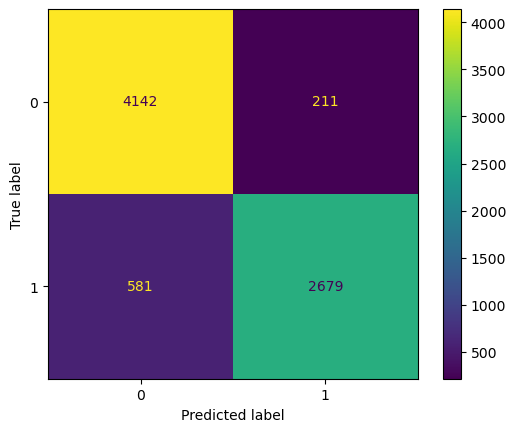

In [80]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_true, train_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()

plt.show()

## Inspecting the Confusion Matrix

Similar to the approach taken in lesson 2 of the Fast.AI 2022 edition (where we used the first trained model to find the picture which had the top losses), let's review the incorrectly labeled tweets. Maybe this will give us some insights how we can improve the training data.

I apologize up-front for the long lists of tweets below, simply skip over them.

In [81]:
# get the indexes of false positives
fp_index = [i for i, (t, p) in enumerate(zip(train_true, train_preds)) if t == 0 and p == 1]

# get the indexes of false negatives
fn_index = [i for i, (t, p) in enumerate(zip(train_true, train_preds)) if t == 1 and p == 0]

#print("False Positive Indexes:", fp_index)
#print("False Negative Indexes:", fn_index)

In [82]:
pd.options.display.max_rows = 700 #Potentially, we need to review a lot of tweets

First, let's review the false positives. While reading through the tweets, I got the impression that the false positives were indeed mostly incorrect predictions made by the model - even though there is quite some room for interpretation. (Therefore I limit the output list below)

In [83]:
train['pred'] = train_preds

In [84]:
#display false positives -> Are there actual disaster tweets in there? -> by sampling ok
train.loc[fp_index, ['id', 'input', 'target', 'pred']][:10]

,id,input,target,pred
71,102,[CLS][HB]stlouis[HE] [HB]caraccidentlawyer[HE] Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident tee_,0.0,1
150,215,[CLS][MB]mickinyman[ME] [MB]TheAtlantic[ME] That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best.,0.0,1
200,281,[CLS]HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS AND_ https://t.co/SeK6MQ6NJF,0.0,1
221,314,[CLS]BOOM! Your country was just entirely annihilated by a h_ Britain https://t.co/IrFCn71sZv,0.0,1
223,316,[CLS]One thing for sure-God has promised Israel will not be annihilated. But...the horror of Iran w/nukes. https://t.co/xn09Mx6sxy,0.0,1
248,353,[CLS]World Annihilation vs Self Transformation http://t.co/pyehwodWun Aliens Attack to Exterminate Humans http://t.co/pB2N77nSKz,0.0,1
380,546,[CLS]Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW,0.0,1
397,574,[CLS]Mourning notices for stabbing arson victims stir 'politics of grief' in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe,0.0,1
420,609,[CLS]Bloor/Ossington arsonist also burned a mattress on Northumberland St [HB]cbcto[HE] http://t.co/wpDvT31sne,0.0,1
423,613,[CLS][HB]Vegetarian[HE] [HB]Vegan[HE] Video shows arsonist torching popular BK restaurant Strictly Vegetarian... http://t.co/kxpLYoM9RR [HB]GoVegan[HE] [HB]UniteBlue[HE],0.0,1


Now, let's review the false negatives. These tweets contain quite a few mislabled ones. Feel free to read through the tweets for simply skip to the next cell for my analysis:

In [85]:
#display false negatives
train.loc[fn_index, ['input', 'target', 'pred']]

,input,target,pred
56,[CLS]TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF,1.0,0
73,[CLS]BigRigRadio Live Accident Awareness,1.0,0
99,[CLS]only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive .,1.0,0
171,[CLS]Early wake up call from my sister begging me to come over ride w/her in the ambulance to the hospital [HB]RODKiai[HE],1.0,0
195,[CLS]when you don't know which way an ambulance is coming from,1.0,0
214,[CLS]Annihilated Abs . ?? http://t.co/1xPw292tJe,1.0,0
229,[CLS]Ready to get annihilated for the BUCS game,1.0,0
234,[CLS][MB]TomcatArts[ME] thus explaining why you were all annihilated. But the few or in this case you the only survivor evolved and became godlike,1.0,0
243,[CLS][MB]rvfriedmann[ME] Hell is just a fraction of his belief of total annihilation destruction of USA [MB]LodiSilverado[ME] [MB]ritzy_jewels[ME],1.0,0
247,[CLS]annihilating quarterstaff of annihilation,1.0,0


Reading through the tweets, I collected quite a few ones that I feel are incorrectly labeled:

In [86]:
def display_problematic_lines2():

    return train.loc[[321, 3747,
                      #575, 587,
                      4713, 7365, 6017, 7244, #especially here are a lot of mislabled tweets
                     249,# -> Link?
                    264, #-> more?
                    277, #->
                    290,
                    301,
                    354,
                    356,
                    361,
                    396,
                    466,
                    467,
                    502,
                    533,
                    544,
                    545,
                    556,
                    590,# -> FedEx
                    593,
                    615,
                    621,
                    625,
                    649,
                    719,
                    728,
                    733,
                    753,
                    819,
                    821,
                    857,
                    863],
 
                     ['id', 'input', 'target', 'avg_target', 'pred']]

display_problematic_lines2()

,id,input,target,avg_target,pred
321,467,[CLS]Armageddon https://t.co/uCSUDk3q1d,1.0,1.0,0
3747,5324,[CLS]Setting things on fire is always an option,1.0,1.0,0
4713,6701,[CLS]Imagine a room with walls that are lava lamps.,1.0,1.0,0
7365,10545,[CLS]Texas Seeks Comment on Rules for Changes to WindstormInsurer http://t.co/92fwtObi3U,1.0,1.0,0
6017,8595,[CLS]Oil and Gas Exploration http://t.co/PckF0nl2yN,1.0,1.0,0
7244,10374,[CLS]I will adamantly opposed to nuclear weapons.,1.0,1.0,0
249,354,[CLS]:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via [MB]YouTube[ME],1.0,1.0,0
264,381,[CLS]Stop the Annihilation of the Salt River Wild Horses! http://t.co/wVobVVtXKg via [MB]Change[ME],1.0,1.0,0
277,404,[CLS]Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 [HB]internetradio[HE] [HB]collegeradi[HE]_,1.0,1.0,0
290,424,[CLS]Dad bought a DVD that looks like a science doc on the front but I read the back and it's actually about the impending biblical apocalypse,1.0,1.0,0


In [87]:
#all of these are no disaster tweets
train.loc[(train['input'].str.lower().str.contains("texas")) & (train['input'].str.lower().str.contains("insurer"))]

,id,keyword,location,text,target,input,text_count,avg_target,pred
7362,10541,windstorm,[N],Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/ei8QqhrEgZ [HB]insurance[HE],0.0,[CLS]Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/ei8QqhrEgZ [HB]insurance[HE],1,0.0,0
7363,10543,windstorm,[N],IJ: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/h132iuL7MU,1.0,[CLS]IJ: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/h132iuL7MU,1,1.0,0
7365,10545,windstorm,[N],Texas Seeks Comment on Rules for Changes to WindstormåÊInsurer http://t.co/92fwtObi3U,1.0,[CLS]Texas Seeks Comment on Rules for Changes to WindstormInsurer http://t.co/92fwtObi3U,1,1.0,0
7370,10552,windstorm,[N],[HB]Insurance[HE] Texas Seeks Comment on Rules for Changes to Windstorm Insurer: The Texas Department of Insurance is... http://t.co/byvUBg0WyE,1.0,[CLS][HB]Insurance[HE] Texas Seeks Comment on Rules for Changes to Windstorm Insurer: The Texas Department of Insurance is... http://t.co/byvUBg0WyE,1,1.0,0
7377,10560,windstorm,"Jakarta, Indonesia",Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BP6MfJHARS,0.0,[CLS]Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BP6MfJHARS,1,0.0,0
7379,10562,windstorm,"San Diego, CA",Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BNNIdfZWbd,0.0,[CLS]Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BNNIdfZWbd,1,0.0,0
7388,10573,windstorm,LYNBROOK,[HB]Insurance[HE]: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/rb02svlpPu,0.0,[CLS][HB]Insurance[HE]: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/rb02svlpPu,1,0.0,0
7392,10578,windstorm,"Sugar Land, TX",Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BZ07c9WthX via [MB]ijournal[ME],0.0,[CLS]Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BZ07c9WthX via [MB]ijournal[ME],1,0.0,0
7397,10584,windstorm,[N],Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/XQIadG9H2w http://t.co/yPEElMjdZY,0.0,[CLS]Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/XQIadG9H2w http://t.co/yPEElMjdZY,1,0.0,0


In [88]:
#all of these are no disaster tweets
train.loc[(train['input'].str.lower().str.contains("reddit")) & (train['input'].str.lower().str.contains("quarantine"))]

,id,keyword,location,text,target,input,text_count,avg_target,pred
5464,7797,quarantine,missouri USA,Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm [HB]onlinecommunities[HE] [HB]reddit[HE] [HB]amageddon[HE] [HB]freespeech[HE] [HB]Business[HE] http://t.co/PAWvNJ4sAP,1.0,[CLS]Reddit Will Now Quarantine_ http://t.co/pkUAMXw6pm [HB]onlinecommunities[HE] [HB]reddit[HE] [HB]amageddon[HE] [HB]freespeech[HE] [HB]Business[HE] http://t.co/PAWvNJ4sAP,1,1.0,0
5465,7799,quarantine,PA,Reddit Will Now Quarantine Offensive Content http://t.co/u9BkQt6XHR,0.0,[CLS]Reddit Will Now Quarantine Offensive Content http://t.co/u9BkQt6XHR,1,0.0,0
5466,7800,quarantine,South africa,Reddit Will Now Quarantine Offensive Content http://t.co/8S0mTwRumQ [HB]Technology[HE] [HB]technews[HE] [HB]puledo_tech_update[HE],0.0,[CLS]Reddit Will Now Quarantine Offensive Content http://t.co/8S0mTwRumQ [HB]Technology[HE] [HB]technews[HE] [HB]puledo_tech_update[HE],1,0.0,0
5467,7801,quarantine,Bucharest,[HB]Reddit[HE] updates [HB]content[HE] [HB]policy[HE] promises to quarantine 'extremely offensive' communities http://t.co/EHGtZhKAn4,1.0,[CLS][HB]Reddit[HE] updates [HB]content[HE] [HB]policy[HE] promises to quarantine 'extremely offensive' communities http://t.co/EHGtZhKAn4,1,1.0,0
5468,7802,quarantine,[N],Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/tHnExicGQe,0.0,[CLS]Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/tHnExicGQe,1,0.0,0
5469,7803,quarantine,"Mumbai, Maharashtra",RT skanndTyagi WIRED : Reddit will now quarantine offensive content http://t.co/H0xUNJ3C7C (http://t.co/UuEw4MJLesÛ_ Û_,0.0,[CLS]RT skanndTyagi WIRED : Reddit will now quarantine offensive content http://t.co/H0xUNJ3C7C (http://t.co/UuEw4MJLes_ _,1,0.0,0
5470,7804,quarantine,"Joshua Tree, CA",Reddit Will Now Quarantine Offensive Content http://t.co/WosYPVQUFI http://t.co/XW8SDS1Tjp,1.0,[CLS]Reddit Will Now Quarantine Offensive Content http://t.co/WosYPVQUFI http://t.co/XW8SDS1Tjp,1,1.0,0
5472,7809,quarantine,[N],Check Out: 'Reddit Will Now Quarantine Offensive Content' http://t.co/Ew5wZC07Fo,0.0,[CLS]Check Out: 'Reddit Will Now Quarantine Offensive Content' http://t.co/Ew5wZC07Fo,1,0.0,0
5473,7810,quarantine,"Bangalore, INDIA",[HB]Bangalore[HE] Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/Of3Q75fGeU [HB]Startups[HE] [HB]in[HE],0.0,[CLS][HB]Bangalore[HE] Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/Of3Q75fGeU [HB]Startups[HE] [HB]in[HE],1,0.0,0
5474,7812,quarantine,[N],Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/KmTwA3n1Gf,0.0,[CLS]Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/KmTwA3n1Gf,1,0.0,0


In [89]:
#all of these are no disaster tweets
train.loc[(train['input'].str.lower().str.contains("fedex")) & (train['input'].str.lower().str.contains("trans"))]

,id,keyword,location,text,target,input,text_count,avg_target,pred
573,829,bioterror,Washington D.C.,News: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/xteZGjfs8A,1.0,[CLS]News: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/xteZGjfs8A,1,1.0,1
574,832,bioterror,NC,FedEx no longer will transport bioterror germs http://t.co/qfjjDxes7G via [MB]USATODAY[ME],0.0,[CLS]FedEx no longer will transport bioterror germs http://t.co/qfjjDxes7G via [MB]USATODAY[ME],1,0.0,0
575,833,bioterror,[N],USA TODAY: .[MB]FedEx[ME] will no longer to transport bioterror pathogens after ... - http://t.co/iaDlSlqdpd [HB]NewsInTweets[HE] http://t.co/o8y1suL4Ow,0.0,[CLS]USA TODAY: .[MB]FedEx[ME] will no longer to transport bioterror pathogens after ... - http://t.co/iaDlSlqdpd [HB]NewsInTweets[HE] http://t.co/o8y1suL4Ow,1,0.0,0
576,834,bioterror,"West Virginia, USA",FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/HQsU8LWltH via [MB]usatoday[ME],1.0,[CLS]FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/HQsU8LWltH via [MB]usatoday[ME],1,1.0,1
578,836,bioterror,British girl in Texas,FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J,0.0,[CLS]FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J,1,0.0,1
579,837,bioterror,"Silver Spring, MD",.[MB]APHL[ME] responds: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/cGdj3dRso9,1.0,[CLS].[MB]APHL[ME] responds: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/cGdj3dRso9,1,1.0,1
580,838,bioterror,USA,[HB]News[HE] FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps (say what?): åÊFedEx no... http://t.co/K0Y7xFxmXA [HB]TCOT[HE],1.0,[CLS][HB]News[HE] FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps (say what?): FedEx no... http://t.co/K0Y7xFxmXA [HB]TCOT[HE],1,1.0,1
581,840,bioterror,"Phoenix, AZ",FedEx to stop transporting bioterror germs after lab mishaps: FedEx has stopped transporting certain research ... http://t.co/y3dM9uLqxG,1.0,[CLS]FedEx to stop transporting bioterror germs after lab mishaps: FedEx has stopped transporting certain research ... http://t.co/y3dM9uLqxG,1,1.0,1
584,843,bioterror,"Wilmington, DE",FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via [MB]usatoday[ME],0.0,[CLS]FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via [MB]usatoday[ME],1,0.0,1
586,846,bioterror,Memphis,FedEx not willing to transport research specimens of potential bioterror pathogens in wake of anthrax lab mishaps http://t.co/cM8UnI1mRG,1.0,[CLS]FedEx not willing to transport research specimens of potential bioterror pathogens in wake of anthrax lab mishaps http://t.co/cM8UnI1mRG,1,1.0,1


I will resuse the findings of the mislabeled tweets in the next iteration of this notebook. Here is the LINK.

# Predictions

After the training is done, let's load the test set and get the predictions.

In [90]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Cleaning the test data:

In [91]:
eval_df = clean_df(eval_df)

In [92]:
eval_df.head()

,id,keyword,location,text,input
0,0,[N],[N],Just happened a terrible car crash,[CLS]Just happened a terrible car crash
1,2,[N],[N],"Heard about [HB]earthquake[HE] is different cities, stay safe everyone.","[CLS]Heard about [HB]earthquake[HE] is different cities, stay safe everyone."
2,3,[N],[N],"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","[CLS]there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,[N],[N],Apocalypse lighting. [HB]Spokane[HE] [HB]wildfires[HE],[CLS]Apocalypse lighting. [HB]Spokane[HE] [HB]wildfires[HE]
4,11,[N],[N],Typhoon Soudelor kills 28 in China and Taiwan,[CLS]Typhoon Soudelor kills 28 in China and Taiwan


In [93]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [94]:
import torch

In [95]:
predictions = torch.empty((0,len(eval_df)))
predictions

tensor([], size=(0, 3263))

Doing the predictions, same as above: The loop caters for potential multiple trainers.

In [96]:
for trainer in trainers:
    preds = trainer.predict(eval_ds).predictions.astype(float)
    #preds2 = [ 1 if element > 0.6 else 0 for element in preds.squeeze()]
    prediction = torch.tensor(preds)
    predictions = torch.cat([predictions,prediction.T],dim=0)

The following cells explore the result and visualize it in a histogram to see how confident the model is.

In [97]:
predictions.shape

torch.Size([1, 3263])

In [98]:
predictions

tensor([[1.0407, 1.0535, 1.0238,  ..., 1.0508, 1.0553, 1.0626]],
       dtype=torch.float64)

In [99]:
metrics = trainer.predict(eval_ds).metrics

In [100]:
predictions = predictions.mean(dim=0)
predictions

tensor([1.0407, 1.0535, 1.0238,  ..., 1.0508, 1.0553, 1.0626],
       dtype=torch.float64)

In [101]:
metrics

{'test_runtime': 45.2908,
 'test_samples_per_second': 72.046,
 'test_steps_per_second': 9.008}

In [102]:
preds = predictions.numpy()

In [103]:
preds[:20]

array([1.04066098, 1.05353618, 1.02384949, 1.04765928, 1.01529777,
       1.03123772, 0.03334056, 0.01147157, 0.01450774, 0.01147548,
       0.01850769, 0.01321647, 0.0212689 , 0.00405677, 0.01239002,
       1.02750051, 0.02232978, 0.02440112, 0.02840946, 0.00759593])

Let's visualize the results:

In [104]:
preds.max()

1.0699498653411865

In [105]:
preds.min()

-0.00029001731309108436

In [106]:
import matplotlib.pyplot as plt
import numpy as np

In [107]:
bins = np.arange (-0.1, 1.3, 0.1)

In [108]:
np.histogram(preds, bins=bins)

(array([   1, 1971,   61,   19,   11,    9,    9,   16,   13,   31,  205,
         917,    0]),
 array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
         1. ,  1.1,  1.2]))

In [109]:
hist = np.histogram(preds, bins=bins)
hist[0]

array([   1, 1971,   61,   19,   11,    9,    9,   16,   13,   31,  205,
        917,    0])

In [110]:
def remove_left_right(counts, bins):
    while counts[0] <= counts[1]:
        counts = counts[1:]
        bins = bins[1:]
    
    while counts[-1] <= counts[-2]:
        counts = counts[:-1]
        bins = bins[:-1]
    
    return counts,bins

Finding the minimum, i.e. finding the point which sets apart a disaster tweet from a non-disaster tweet was an interesting problem. In the end, however, I reverted back to the constant 0.6 since for some runs, erratic local minimal probably were not optimal.

In [111]:
def find_minimum(counts,bins):
    lowest_indices = int(np.where(counts == np.min(counts))[0].mean().round())
    return bins[lowest_indices]

In [112]:
counts,new_bins = remove_left_right(hist[0], hist[1])
minimum = find_minimum(counts,new_bins)
minimum

0.4

In [113]:
min(counts)

9

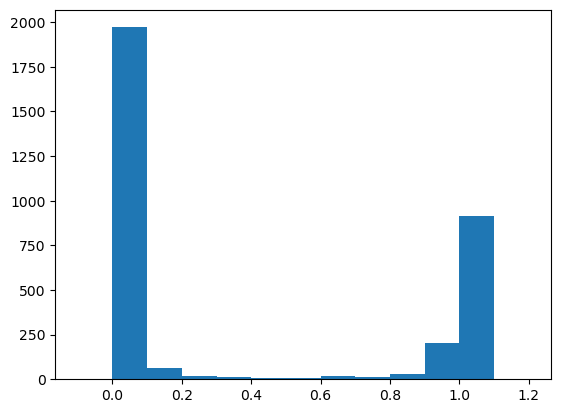

In [114]:
plt.hist(preds, bins=bins);

In [115]:
preds.mean()

0.3902778167168776

In [116]:
np.median(preds)

0.04003792256116867

In [117]:
preds.round().astype(int)[:20]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [118]:
preds2 = [ 1 if element > 0.6 else 0 for element in preds.squeeze()]
preds2[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

Finally, let's create the submission file.

In [119]:
preds = preds2

In [120]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'target': preds
})

submission.to_csv('submission_as.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

22746

# Competition Results

This was the best result of my [baseline notebook](https://www.kaggle.com/code/christianwittmann/nlp-with-disaster-tweets-baseline):

lr = 5e-6, epochs = 20, bs = 256

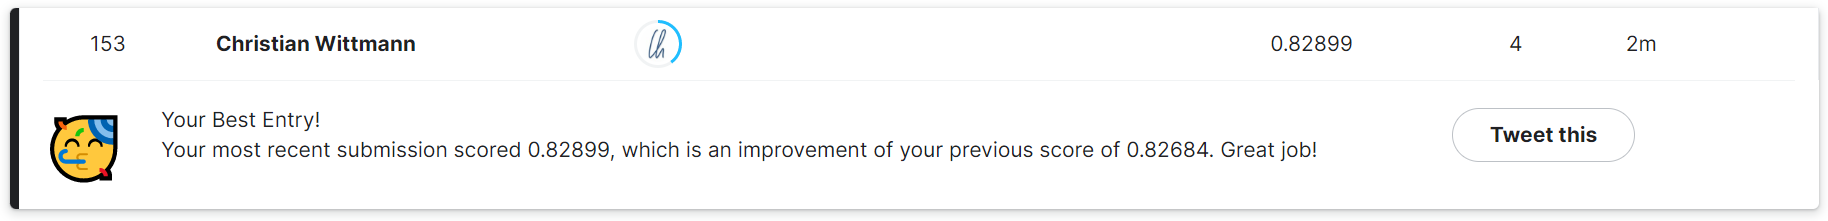

My best submission scored 0.84676. That is an increase of only 2.7 percentage points. The bigger difference is the rank on the leaderboard. At the time of writing 0.84278 put me on rank 34/938. If you deduct the submission which scored 100% (29 submission), I am pretty happy with rank 5. 😀

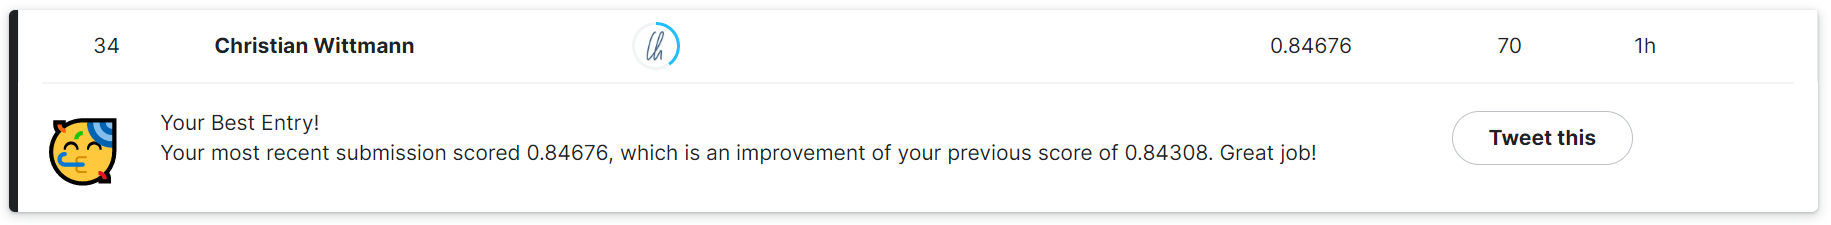